In [1]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate

%matplotlib inline

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.1.0


In [2]:
SEED = 42
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)

### Set FeathersV1 Dataset root directory path

In [3]:
DATASET_DIR = Path(".") / "data" / "feathersv1-dataset"

### Setup project

In [4]:
# Currently we support only Keras models from: https://keras.io/applications/
MODEL_TYPE = "DenseNet121"

# Please select `top_50`, `top_100` or `all` classes count.
CLASSES_COUNT = "top_50"

### Set project name

In [5]:
PROJECT_NAME = f"{MODEL_TYPE}_{CLASSES_COUNT}"

TRAIN_CSV = DATASET_DIR / "data" / f"train_{CLASSES_COUNT}_species.csv"
TEST_CSV = DATASET_DIR / "data" / f"test_{CLASSES_COUNT}_species.csv"

### Set project parameters

In [6]:
# Resize loaded images to this size.
IMG_WIDTH, IMG_HEIGHT = 240, 40

# Model parameters.
BATCH_SIZE = 64
EPOCHS = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Define loads functions

In [7]:
def csv_to_paths(dataset_dir, csv_file):
    with open(csv_file, "r") as readfile:
        readfile.readline()  # skip header

        csv_data = readfile.readlines()

    image_paths = []

    for line in csv_data:
        image_path_parts = [
            x.lower().replace(" ", "_") for x in line.strip().split(",")
        ]

        image_path = (
            dataset_dir
            / "images"
            / image_path_parts[1]
            / image_path_parts[2]
            / image_path_parts[0]
        )

        image_paths.append(image_path.as_posix())

    return image_paths


def read_labels(file_path, label_type):
    # Select position of label in CSV file by type.
    if label_type == "order":
        pos = 1
    elif label_type == "species":
        pos = 2
    else:
        raise Exception("undefined label type")

    # Return classes from CSV file.
    with open(file_path, "r") as readfile:
        readfile.readline()  # skip header
        return [line.strip().split(",")[pos] for line in readfile.readlines()]


def augment(img):
    # Small augmentation for brightness and saturation.
    img = tf.image.random_brightness(img, max_delta=0.15, seed=SEED)
    img = tf.image.random_saturation(img, lower=0.80, upper=1.20, seed=SEED)
    img = tf.image.random_contrast(img, lower=0.80, upper=1.20, seed=SEED)

    # Random left-right flip.
    img = tf.image.random_flip_left_right(img, seed=SEED)

    return img


def process_image(file_path):
    # Load the raw data from the file as a string.
    img = tf.io.read_file(file_path)

    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=3)

    # Rotate if width > height.
    if tf.shape(img)[1] > tf.shape(img)[0]:
        img = tf.image.rot90(img, k=1)
        
    # Apply augmentation.
    img = augment(img)

    # Use `convert_image_dtype` to convert to floats in the [0, 1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def prepare_for_training(ds, cache=False):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    return ds

 ### Load images

In [8]:
X_train_files = tf.data.Dataset.from_tensor_slices(csv_to_paths(DATASET_DIR, TRAIN_CSV))
X_train = X_train_files.map(process_image, num_parallel_calls=AUTOTUNE)

X_test_files = tf.data.Dataset.from_tensor_slices(csv_to_paths(DATASET_DIR, TEST_CSV))
X_test = X_test_files.map(process_image, num_parallel_calls=AUTOTUNE)

 ### Load labels

In [9]:
y_train_labels = read_labels(TRAIN_CSV, label_type="species")
y_test_labels = read_labels(TEST_CSV, label_type="species")

 ### Create Label Encoder

In [10]:
enc = LabelEncoder()
_ = enc.fit(list({*y_train_labels, *y_test_labels}))

 ### Encode labels

In [11]:
y_train_labels = enc.transform(y_train_labels)
y_test_labels = enc.transform(y_test_labels)

 ### Move labels to TensorFlow datasets

In [12]:
y_train = tf.data.Dataset.from_tensor_slices(y_train_labels)
y_test = tf.data.Dataset.from_tensor_slices(y_test_labels)

 ### Join datasets

In [13]:
train_dataset = prepare_for_training(tf.data.Dataset.zip((X_train, y_train)))
test_dataset = tf.data.Dataset.zip((X_test, y_test)).batch(BATCH_SIZE)

 ### Plot train batch

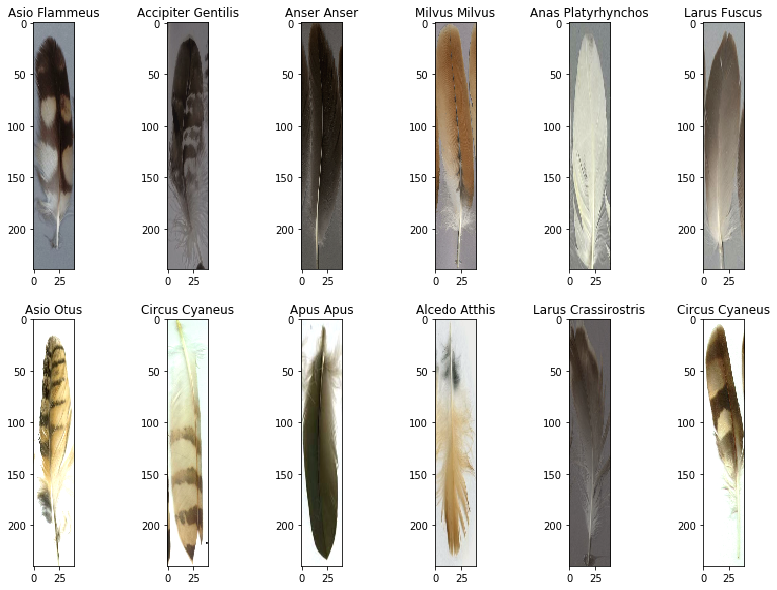

In [14]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(14, 10))
    rows = 2
    cols = 6

    for n in range(cols * rows):
        _ = plt.subplot(rows, cols, n + 1)
        plt.imshow(image_batch[n])
        plt.title(enc.classes_[label_batch[n]])
    plt.show()


image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch.numpy(), label_batch.numpy())

 ## Define model

In [15]:
# TODO Fix paths separator?

metric_sparse_top_1 = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=1, name="sparse_top_1_categorical_accuracy", dtype=None
)

metric_sparse_top_5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=5, name="sparse_top_5_categorical_accuracy", dtype=None
)

callback_save_best_weights = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"results/{PROJECT_NAME}/weights.hdf5",
    monitor="val_sparse_top_5_categorical_accuracy",
    mode="max",
    save_best_only=True,
    verbose=0,
)

callback_csv_logger = tf.keras.callbacks.CSVLogger(
    filename=f"results/{PROJECT_NAME}/training.csv",
    separator=",",
    append=False,
)

In [16]:
(Path("results") / PROJECT_NAME).mkdir(parents=True, exist_ok=True)

model_object = getattr(
    importlib.import_module("tensorflow.keras.applications"),
    MODEL_TYPE,
)

model = model_object(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    classes=len(enc.classes_),
    weights=None,
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[metric_sparse_top_1, metric_sparse_top_5],
)

print("Total {} classes".format(len(enc.classes_)))

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(y_train_labels) // BATCH_SIZE,
    callbacks=[callback_save_best_weights, callback_csv_logger],
)

Total 50 classes
Train for 128 steps, validate for 33 steps
Epoch 1/16
128/128 [==============================] - 75s 584ms/step - loss: 2.9853 - sparse_top_1_categorical_accuracy: 0.2125 - sparse_top_5_categorical_accuracy: 0.5216 - val_loss: 6.3648 - val_sparse_top_1_categorical_accuracy: 0.0281 - val_sparse_top_5_categorical_accuracy: 0.1042
Epoch 2/16
128/128 [==============================] - 57s 447ms/step - loss: 2.0722 - sparse_top_1_categorical_accuracy: 0.4022 - sparse_top_5_categorical_accuracy: 0.7657 - val_loss: 7.0709 - val_sparse_top_1_categorical_accuracy: 0.0330 - val_sparse_top_5_categorical_accuracy: 0.1294
Epoch 3/16
128/128 [==============================] - 57s 446ms/step - loss: 1.5530 - sparse_top_1_categorical_accuracy: 0.5398 - sparse_top_5_categorical_accuracy: 0.8685 - val_loss: 2.9284 - val_sparse_top_1_categorical_accuracy: 0.2700 - val_sparse_top_5_categorical_accuracy: 0.6011
Epoch 4/16
128/128 [==============================] - 56s 440ms/step - loss: 1.

### Plot history

In [17]:
def plot_history(metrics):
    plt.figure(figsize=(12, 10))

    colors = iter(["r", "b", "g"])

    axes = [
        plt.subplot2grid((2, 2), (0, 0)),
        plt.subplot2grid((2, 2), (0, 1)),
        plt.subplot2grid((2, 2), (1, 0), colspan=2),
    ]

    for plots in zip(axes, reversed(metrics)):
        ax, metric = plots

        ax.plot(
            history.history[metric], c=next(colors), marker="x", linewidth=1.8,
        )

        ax.set_xlabel("epoch")
        ax.set_ylabel("value")
        ax.set_title(metric)
        ax.grid()

    plt.show()

### Plot train history

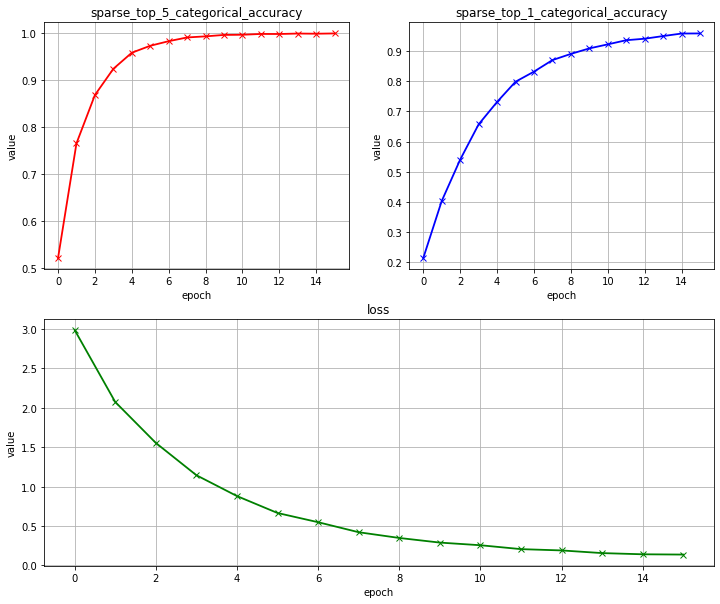

In [18]:
metrics_names = [
    "loss",
    "sparse_top_1_categorical_accuracy",
    "sparse_top_5_categorical_accuracy",
]

plot_history(metrics_names)

### Plot validation history

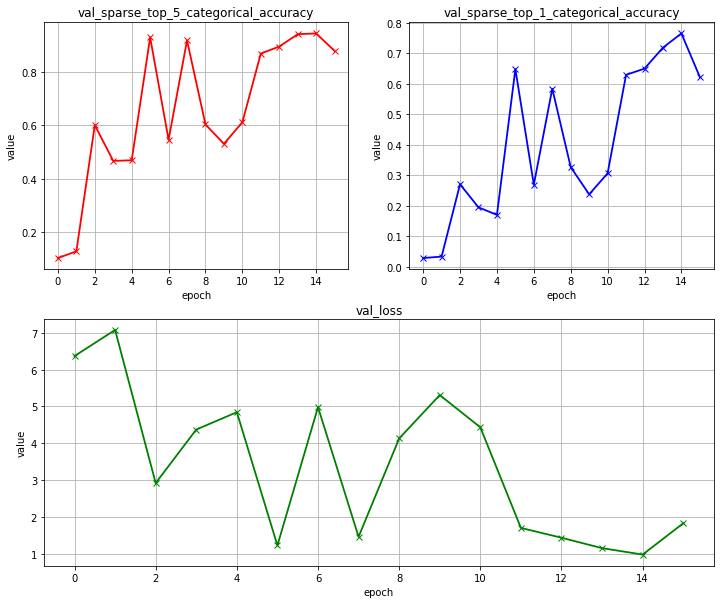

In [19]:
metrics_names = [
    "val_loss",
    "val_sparse_top_1_categorical_accuracy",
    "val_sparse_top_5_categorical_accuracy",
]

plot_history(metrics_names)

### Reload model object with best weights

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)

model_object = getattr(
    importlib.import_module("tensorflow.keras.applications"),
    MODEL_TYPE,
)

# TODO Fix paths separator?

model = model_object(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    classes=len(enc.classes_),
    weights=f"results/{PROJECT_NAME}/weights.hdf5",
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[metric_sparse_top_1, metric_sparse_top_5],
)

 ### Evaluate model

In [21]:
evaluate = model.evaluate(test_dataset)
print(tabulate(zip(model.metrics_names, evaluate), tablefmt="fancy_grid"))

33/33 [==============================] - 12s 364ms/step - loss: 0.9896 - sparse_top_1_categorical_accuracy: 0.7673 - sparse_top_5_categorical_accuracy: 0.9418
╒═══════════════════════════════════╤══════════╕
│ loss                              │ 0.98963  │
├───────────────────────────────────┼──────────┤
│ sparse_top_1_categorical_accuracy │ 0.767329 │
├───────────────────────────────────┼──────────┤
│ sparse_top_5_categorical_accuracy │ 0.941832 │
╘═══════════════════════════════════╧══════════╛


 ### Make prediction

In [22]:
predict_dataset = model.predict(test_dataset)

 ### Plot prediction batch

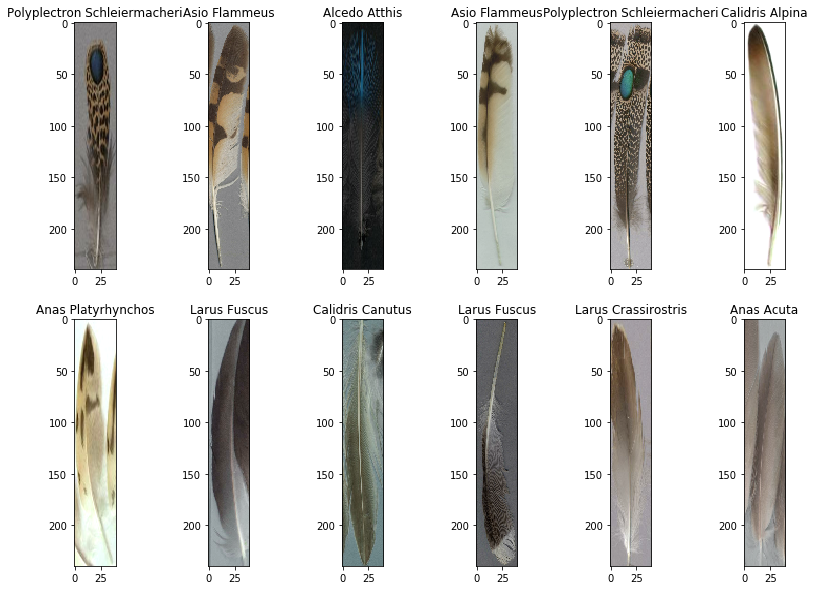

In [23]:
test_image_batch, test_label_batch = next(iter(test_dataset))
show_batch(test_image_batch, test_label_batch)

 ### Plot predicted classes probability

In [24]:
plots_count = 5
top_classes_count = 5

In [25]:
def get_top_predict(predict_dataset, top_count):
    # Get all class names by order.
    classes_names = enc.inverse_transform(
        [x for x in range(len(predict_dataset))]
    )

    # Zip all classes and its probabilities.
    class_and_prob = list(zip(classes_names, predict_dataset))

    # Sort list by probability.
    top_classes = sorted(class_and_prob, key=lambda x: x[1], reverse=True)

    # Return top_count classes.
    return top_classes[:top_count]

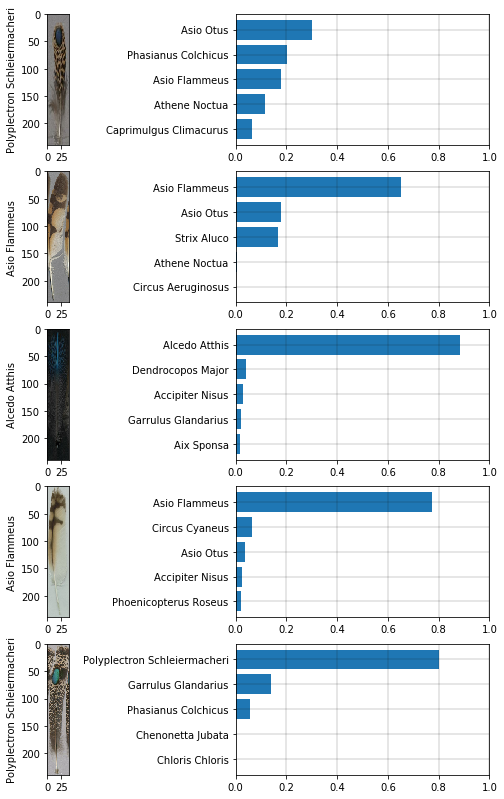

In [26]:
_, plt_arr = plt.subplots(plots_count, 2, figsize=(10, 14))

data = [
    get_top_predict(predict_element, top_classes_count)
    for predict_element in predict_dataset[:plots_count]
]

for i in range(plots_count):
    # Plot image.
    plt_arr[i][0].imshow(test_image_batch[i])
    plt_arr[i][0].set_ylabel(enc.classes_[test_label_batch[i]])

    # Plot barchart probabilities.
    barh_probs = list(reversed([x[1] for x in data[i]]))  # probabilities
    barh_ticks = list(reversed([x[0] for x in data[i]]))  # classes

    plt_arr[i][1].barh(
        y=[n for n in range(top_classes_count)],
        width=barh_probs,
        tick_label=barh_ticks,
    )

    plt_arr[i][1].grid(color="#0c0c0c", linestyle="-", linewidth=0.2)
    plt_arr[i][1].set_xlim(0.0, 1.0)

plt.show()

### Plot classification heatmap

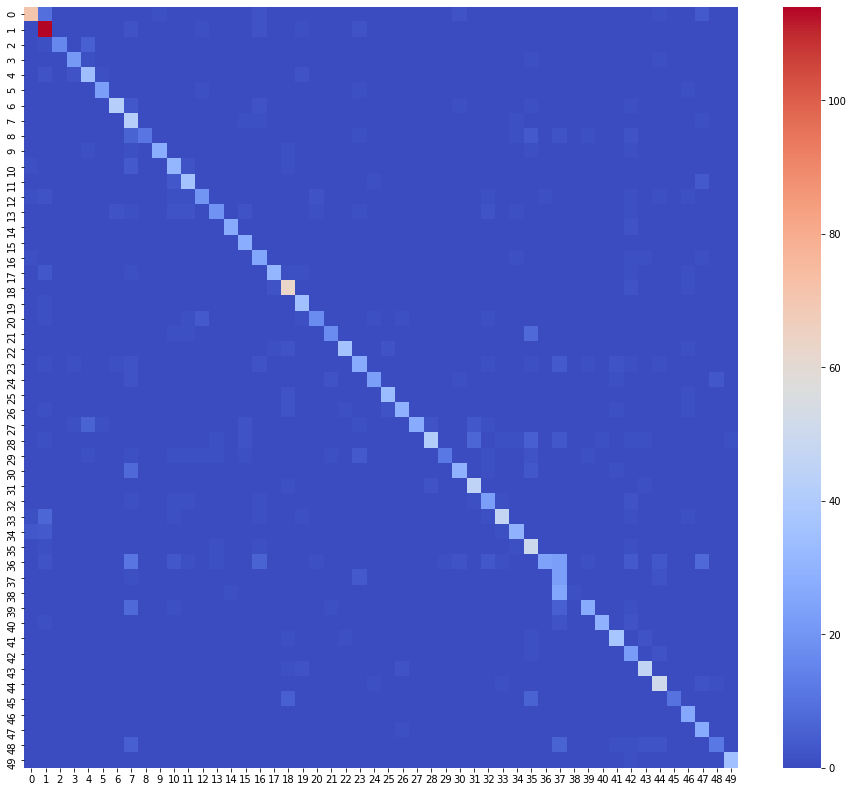

In [27]:
y_pred_labels = np.argmax(predict_dataset, axis=1)

fig, ax = plt.subplots(figsize=(16, 14))

conf_matrix = tf.math.confusion_matrix(y_test_labels, y_pred_labels)

# Generate annotation labels.
annot = enc.inverse_transform([x for x in range(len(enc.classes_))])

# ! Disable annotation for top-100 and all classes !

plot = sns.heatmap(
    conf_matrix,
    cmap="coolwarm",
#     xticklabels=annot,
#     yticklabels=annot,
).get_figure() 

### Additional metrics

In [28]:
print(
    "F1 score micro:", f1_score(y_test_labels, y_pred_labels, average="micro")
)

print(
    "F1 score macro:", f1_score(y_test_labels, y_pred_labels, average="macro")
)

F1 score micro: 0.7619970916141542
F1 score macro: 0.7518214780910902
